In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Train Shape: (891, 12)
Test Shape: (418, 11)
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0  

/tmp/ipykernel_36/1526038759.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train["Age"].fillna(train["Age"].median(), inplace=True)
/tmp/ipykernel_36/1526038759.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

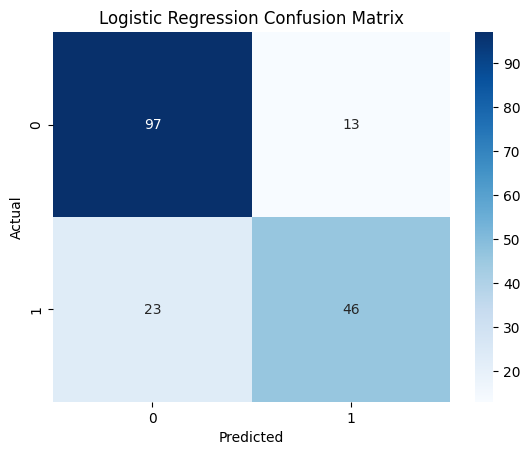


Decision Tree Results:
Accuracy: 0.8324022346368715
              precision    recall  f1-score   support

           0       0.85      0.88      0.87       110
           1       0.80      0.75      0.78        69

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



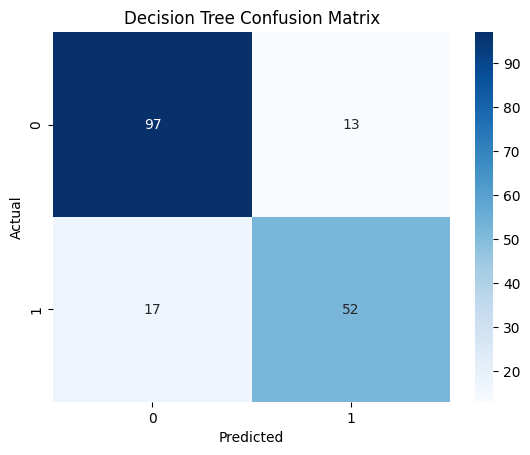


Random Forest Results:
Accuracy: 0.8324022346368715
              precision    recall  f1-score   support

           0       0.84      0.89      0.87       110
           1       0.81      0.74      0.77        69

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



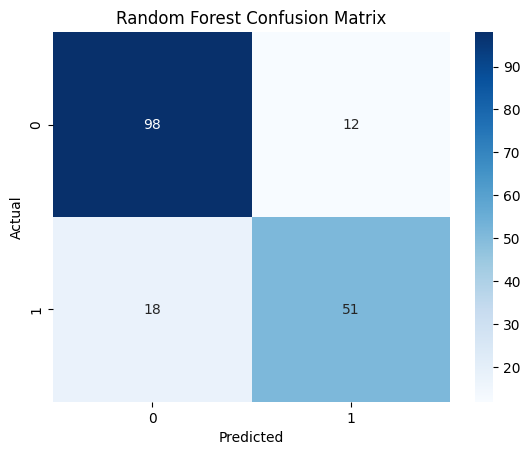


KNN Results:
Accuracy: 0.8156424581005587
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       110
           1       0.77      0.74      0.76        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.82      0.81       179



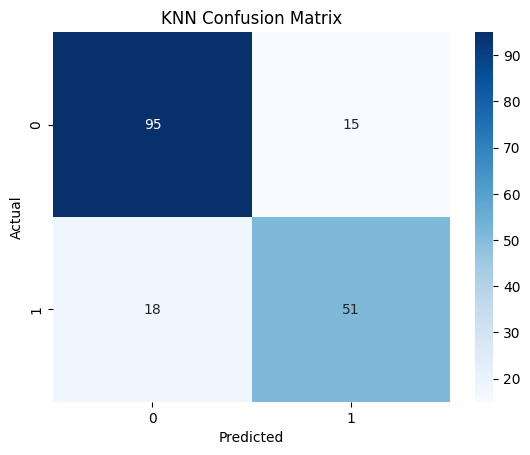


Model Comparison:
                     Accuracy
Logistic Regression  0.798883
Decision Tree        0.832402
Random Forest        0.832402
KNN                  0.815642


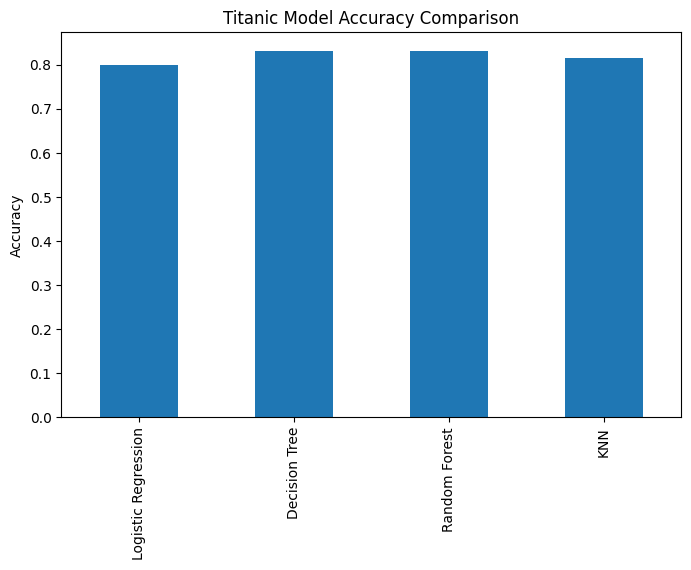


Submission file saved as submission.csv


In [1]:
# Titanic: Machine Learning from Disaster

# 1. Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ----------------------------------------------------------------
# 2. Load Dataset
# ----------------------------------------------------------------
train = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")
gender_submission = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")

print("Train Shape:", train.shape)
print("Test Shape:", test.shape)
print(train.head())

# ----------------------------------------------------------------
# 3. Data Preprocessing
# ----------------------------------------------------------------
# Fill missing values
train["Age"].fillna(train["Age"].median(), inplace=True)
test["Age"].fillna(test["Age"].median(), inplace=True)

train["Embarked"].fillna(train["Embarked"].mode()[0], inplace=True)
test["Embarked"].fillna(test["Embarked"].mode()[0], inplace=True)

test["Fare"].fillna(test["Fare"].median(), inplace=True)

# Drop irrelevant features
train.drop(["PassengerId","Name","Ticket","Cabin"], axis=1, inplace=True)
test_passenger_id = test["PassengerId"]
test.drop(["PassengerId","Name","Ticket","Cabin"], axis=1, inplace=True)

# Encode categorical features
le = LabelEncoder()
for col in ["Sex","Embarked"]:
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])

print("\nProcessed Train Columns:", train.columns)

# ----------------------------------------------------------------
# 4. Split Features & Target
# ----------------------------------------------------------------
X = train.drop("Survived", axis=1)
y = train["Survived"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features for models like Logistic Regression & KNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
test_scaled = scaler.transform(test)

# ----------------------------------------------------------------
# 5. Define Models
# ----------------------------------------------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=7)
}

results = {}

# ----------------------------------------------------------------
# 6. Train & Evaluate Models
# ----------------------------------------------------------------
for name, model in models.items():
    if name in ["Logistic Regression","KNN"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_val_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
    
    acc = accuracy_score(y_val, y_pred)
    results[name] = acc
    
    print(f"\n{name} Results:")
    print("Accuracy:", acc)
    print(classification_report(y_val, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# ----------------------------------------------------------------
# 7. Model Comparison
# ----------------------------------------------------------------
results_df = pd.DataFrame.from_dict(results, orient="index", columns=["Accuracy"])
print("\nModel Comparison:")
print(results_df)

results_df.plot(kind="bar", figsize=(8,5), legend=False)
plt.title("Titanic Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()

# ----------------------------------------------------------------
# 8. Generate Submission (using best model, e.g. Random Forest)
# ----------------------------------------------------------------
best_model = RandomForestClassifier(n_estimators=200, random_state=42)
best_model.fit(X, y)
predictions = best_model.predict(test)

submission = pd.DataFrame({
    "PassengerId": test_passenger_id,
    "Survived": predictions
})

submission.to_csv("submission.csv", index=False)
print("\nSubmission file saved as submission.csv")
